> Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression


#### Preprocessing

Loading CSV

In [3]:

df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")
display(df_lagged.head(3))

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter,Totaal_verkochte_wegvoertuigen
0,2007-07-01,0,1,0,22,14.0,22.0,9.0,6.2,1.451,...,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3,124
1,2007-08-01,0,1,0,22,12.0,17.0,9.0,5.6,1.415,...,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3,96
2,2007-09-01,0,1,0,22,10.0,12.0,9.0,5.0,1.422,...,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3,120


Reformat Time Column

Datasplitting

In [4]:
# Walk-forward split: start with 80% as initial train, then identify test points
drop_cols = ['Periode', 'Totaal_verkochte_wegvoertuigen']
target_col = 'Totaal_verkochte_wegvoertuigen'
feature_cols = [col for col in df_lagged.columns if col not in drop_cols]

initial_train_size = int(len(df_lagged) * 0.8)
walkforward_train_sizes = []
walkforward_test_points = []

X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    
    walkforward_train_sizes.append(len(X_train))
    walkforward_test_points.append(y_test)  # Optional: you can skip storing this

print(f"Total walk-forward steps: {len(walkforward_test_points)}")




Total walk-forward steps: 43


In [20]:
# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

### Model training op elke feature

#### Linear Regression Baseline

Linear Regression Walk-Forward (Lagged Features Only):
MAPE: 12.65%
MAE: 2762.93
RMSE: 3752.66
R²: 0.6377


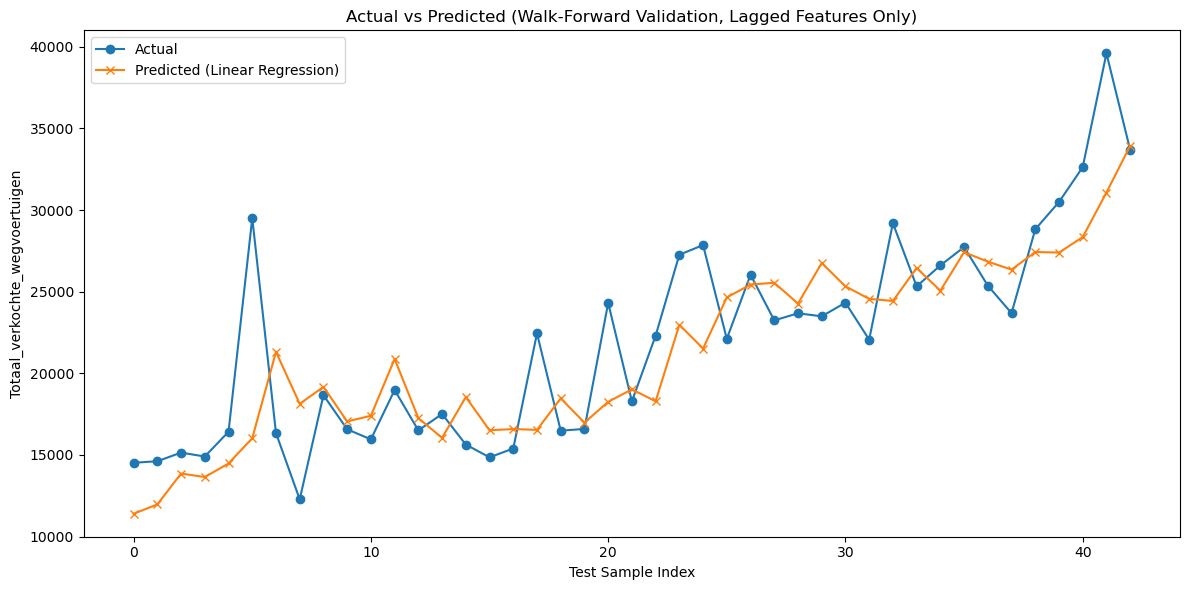

In [5]:

# Only use lagged features for linear regression
lagged_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6']

def walk_forward_validation(df, features, target_col):
    """
    Perform walk-forward validation using Linear Regression on the given dataframe.
    Returns MAE, RMSE, R2, MAPE, predictions, and actuals.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape, predictions, actuals

# Evaluate walk-forward validation using only lagged features
mae, rmse, r2, mape, predictions, actuals = walk_forward_validation(df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen')

print(f"Linear Regression Walk-Forward (Lagged Features Only):")
print(f"MAPE: {mape:.2f}%")

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values for the walk-forward validation (Lagged Features Only)
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', marker='o')
plt.plot(predictions, label='Predicted (Linear Regression)', marker='x')
plt.title('Actual vs Predicted (Walk-Forward Validation, Lagged Features Only)')
plt.xlabel('Test Sample Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()


#### All features

Linear Regression Walk-Forward (All Features):
MAPE: 15.48%
MAE: 3386.96
RMSE: 4441.61
R²: 0.4925


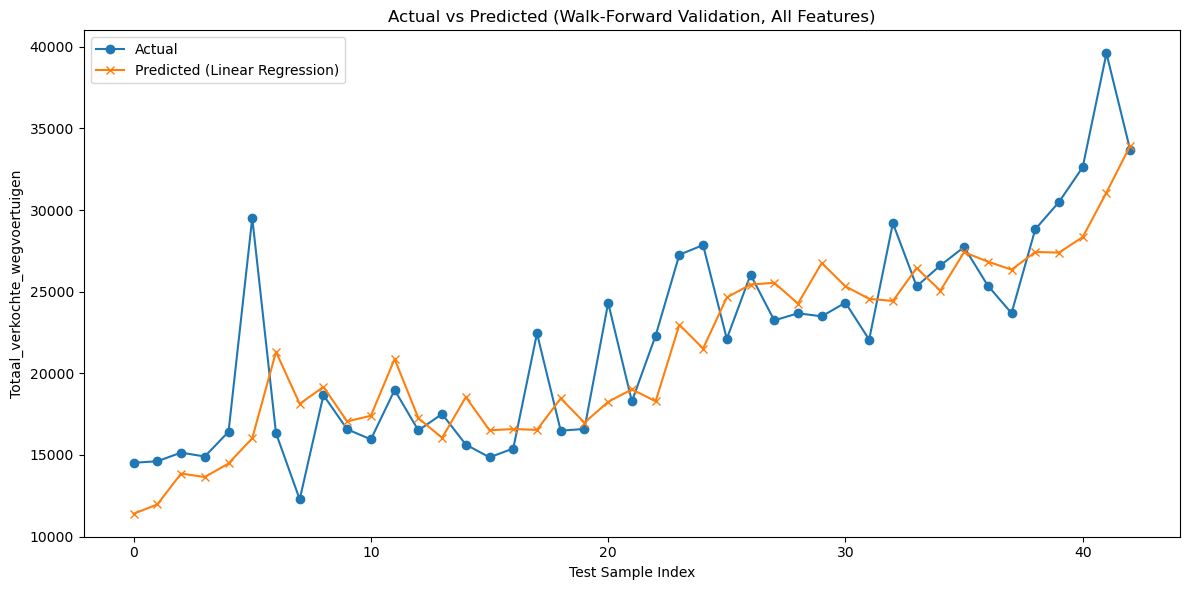

In [6]:
from sklearn.linear_model import LinearRegression

def walk_forward_validation(df, features, target_col):
    """
    Perform walk-forward validation using Linear Regression on the given dataframe.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Evaluate walk-forward validation using all features (feature_cols)
mae, rmse, r2, mape = walk_forward_validation(df_lagged, feature_cols, 'Totaal_verkochte_wegvoertuigen')

print(f"Linear Regression Walk-Forward (All Features):")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values for the walk-forward validation (All Features)
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', marker='o')
plt.plot(predictions, label='Predicted (Linear Regression)', marker='x')
plt.title('Actual vs Predicted (Walk-Forward Validation, All Features)')
plt.xlabel('Test Sample Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()



#### Gebruik van elestic net
er was nauwelijks verschil met Lasso en ridge, daarom gekozen om elastic net te gebruiken.

#### Only lag

ElasticNet Walk-Forward (Lagged Features Only):
MAPE: 12.65%
MAE: 2762.93
RMSE: 3752.66
R²: 0.6377


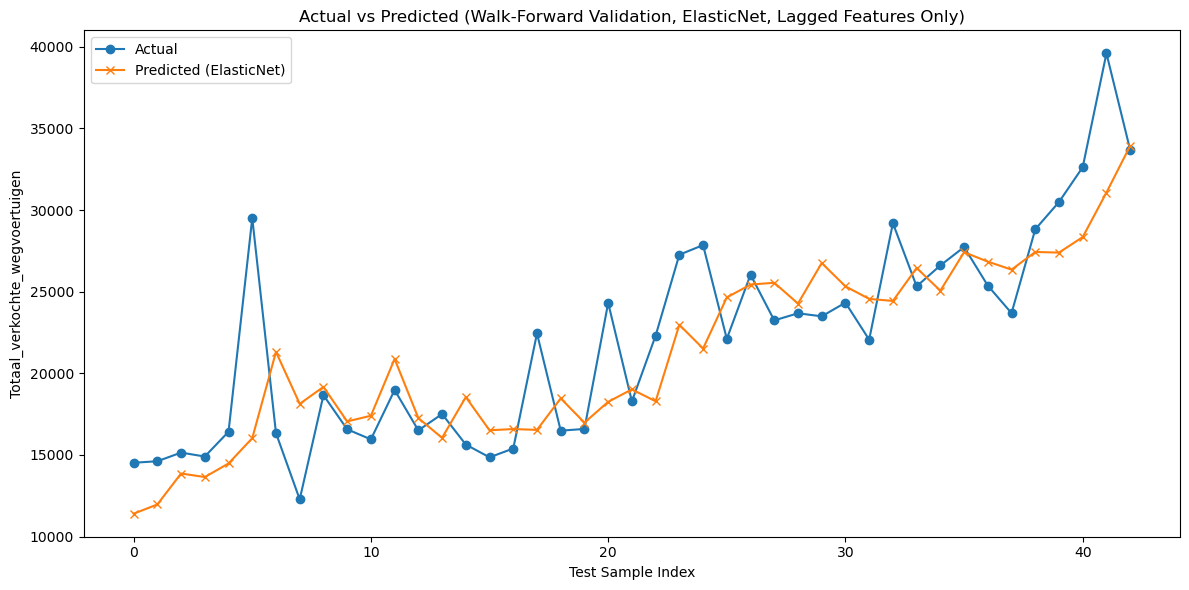

In [8]:
from sklearn.linear_model import ElasticNet

def walk_forward_validation_elasticnet(df, features, target_col, alpha=1.0, l1_ratio=0.5):
    """
    Perform walk-forward validation using ElasticNet on the given dataframe.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape, predictions, actuals

# Evaluate walk-forward validation using only lagged features and ElasticNet
mae, rmse, r2, mape, predictions, actuals = walk_forward_validation_elasticnet(df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen')

print(f"ElasticNet Walk-Forward (Lagged Features Only):")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', marker='o')
plt.plot(predictions, label='Predicted (ElasticNet)', marker='x')
plt.title('Actual vs Predicted (Walk-Forward Validation, ElasticNet, Lagged Features Only)')
plt.xlabel('Test Sample Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()


#### All features

ElasticNet Walk-Forward (All Features):
MAPE: 12.72%
MAE: 2942.97
RMSE: 4227.54
R²: 0.5402


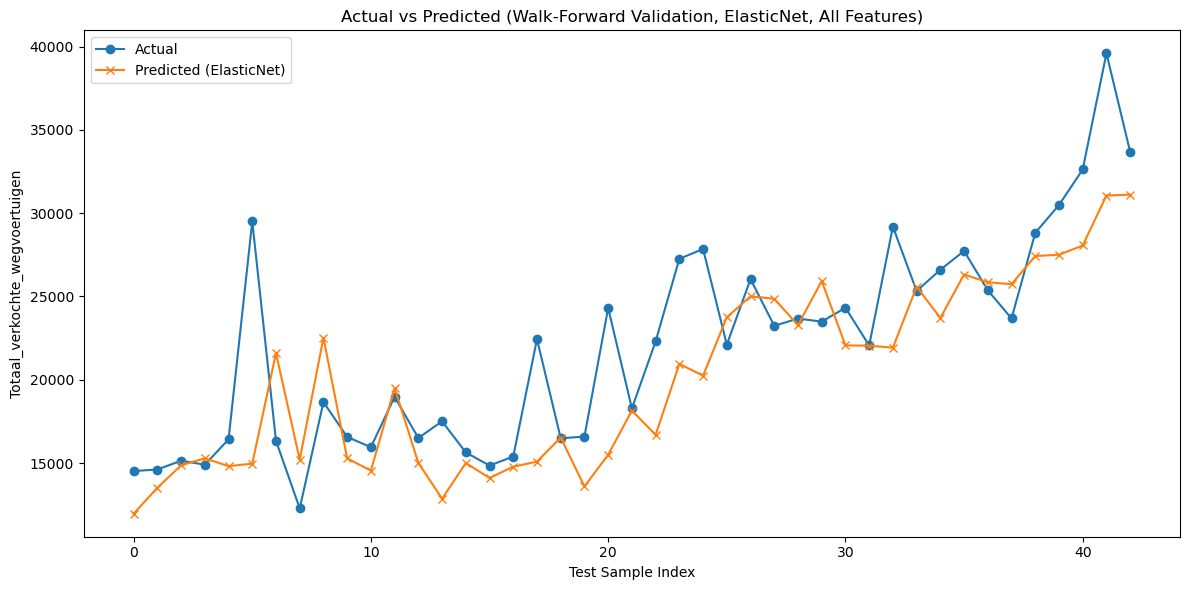

In [7]:
from sklearn.linear_model import ElasticNet

def walk_forward_validation(df, features, target_col, alpha=1.0, l1_ratio=0.5):
    """
    Perform walk-forward validation using ElasticNet on the given dataframe.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape, predictions, actuals

# Example: alpha=1.0, l1_ratio=0.5 (default ElasticNet)
mae, rmse, r2, mape, predictions, actuals = walk_forward_validation(df_lagged, feature_cols, 'Totaal_verkochte_wegvoertuigen')

print(f"ElasticNet Walk-Forward (All Features):")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', marker='o')
plt.plot(predictions, label='Predicted (ElasticNet)', marker='x')
plt.title('Actual vs Predicted (Walk-Forward Validation, ElasticNet, All Features)')
plt.xlabel('Test Sample Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()


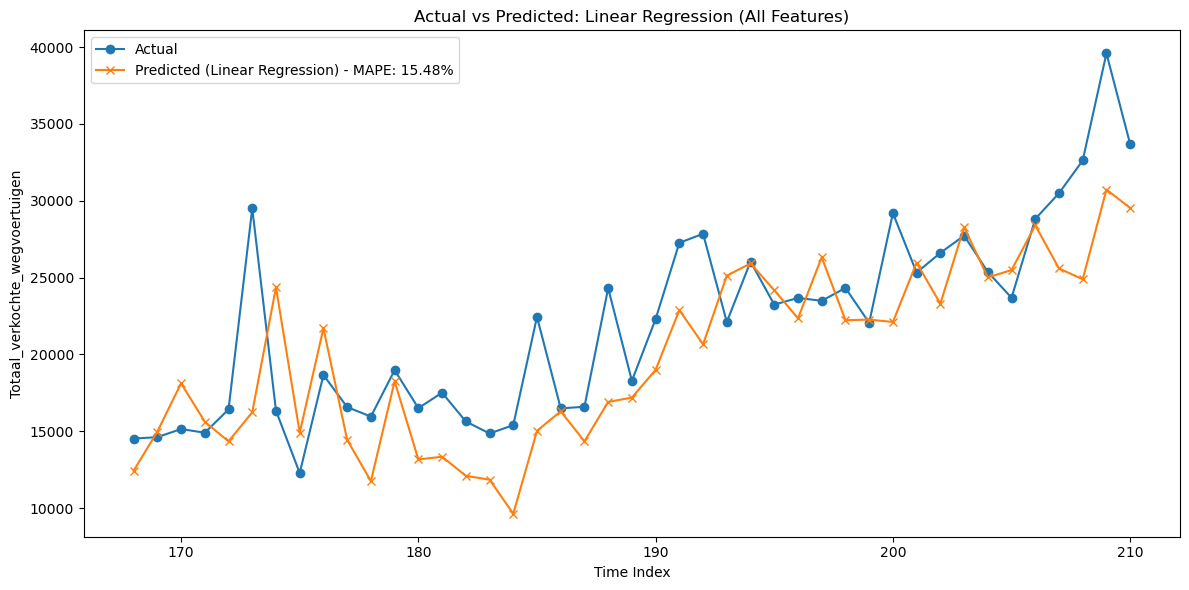

In [11]:
# Prepare X_all and y_all using feature_cols and target_col
X_all = df_lagged[feature_cols].values
y_all = df_lagged[target_col].values

# Calculate predictions for Linear Regression using walk-forward validation (All Features)
lr_predictions = []
lr_actuals = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X_all[:i], y_all[:i]
    X_test, y_test = X_all[i], y_all[i]
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test.reshape(1, -1))[0]
    lr_predictions.append(y_pred)
    lr_actuals.append(y_test)

# Calculate MAPE for Linear Regression
mape_lr = np.mean(np.abs((np.array(lr_actuals) - np.array(lr_predictions)) / np.array(lr_actuals))) * 100

# Plot actual vs predicted for Linear Regression
plt.figure(figsize=(12, 6))
plt.plot(range(initial_train_size, len(df_lagged)), lr_actuals, label='Actual', marker='o')
plt.plot(range(initial_train_size, len(df_lagged)), lr_predictions, label=f'Predicted (Linear Regression) - MAPE: {mape_lr:.2f}%', marker='x')
plt.title('Actual vs Predicted: Linear Regression (All Features)')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()

#### Arima

In [17]:
from statsmodels.tsa.arima.model import ARIMA

def walk_forward_arima(df, target_col, order=(1,1,1)):
    """
    Walk-forward validation using ARIMA (univariate).
    Returns MAE, RMSE, R2, and MAPE.
    """
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        train_y = y[:i]
        test_y = y[i]
        # Fit ARIMA on train set
        model = ARIMA(train_y, order=order)
        model_fit = model.fit()
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)
        actuals.append(test_y)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Evaluate ARIMA (univariate, only target column)
mae, rmse, r2, mape = walk_forward_arima(df_lagged, 'Totaal_verkochte_wegvoertuigen', order=(1,1,1))
print(f"ARIMA Walk-Forward:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.3f}\nMAPE: {mape:.2f}%")

ARIMA Walk-Forward:
MAE: 2859.26
RMSE: 4172.10
R²: 0.552
MAPE: 12.23%


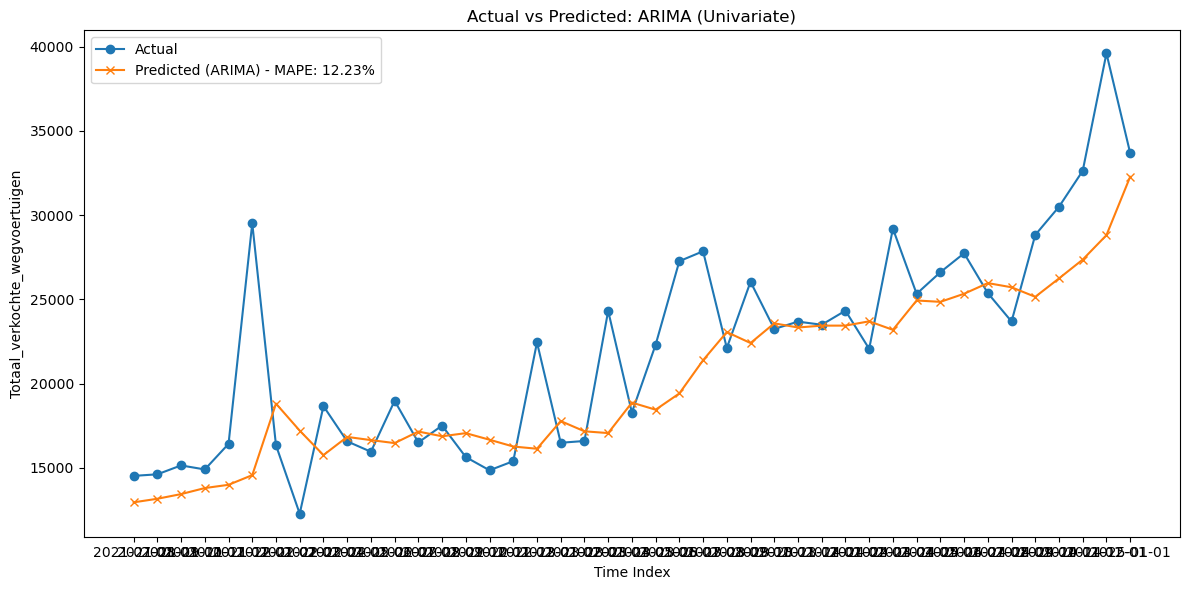

(array([0., 1.]), [Text(0.0, 0, 'Jan 1970'), Text(1.0, 0, 'Jan 1970')])

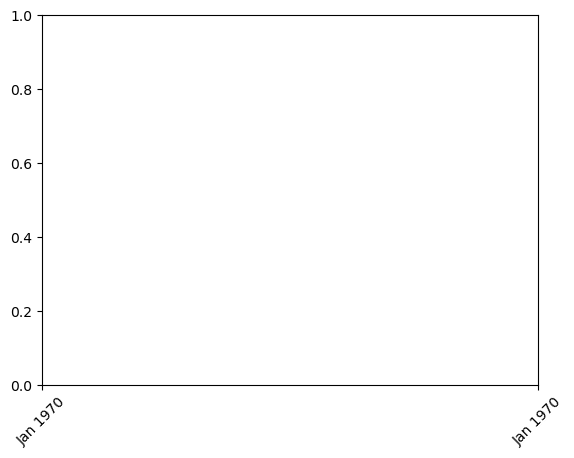

In [29]:
# Plot ARIMA actual vs predicted with MAPE annotation

# Recompute ARIMA walk-forward predictions for plotting
arima_preds = []
arima_actuals = []
y_arima = df_lagged['Totaal_verkochte_wegvoertuigen'].values

for i in range(initial_train_size, len(df_lagged)):
    train_y = y_arima[:i]
    test_y = y_arima[i]
    model = ARIMA(train_y, order=(1,1,1))
    model_fit = model.fit()
    y_pred = model_fit.forecast()[0]
    arima_preds.append(y_pred)
    arima_actuals.append(test_y)

# Calculate MAPE for ARIMA
arima_mape = np.mean(np.abs((np.array(arima_actuals) - np.array(arima_preds)) / np.array(arima_actuals))) * 100

# Define idx for plotting
idx = df_lagged['Periode'].iloc[initial_train_size:]


# Plot
plt.figure(figsize=(12, 6))
plt.plot(idx, arima_actuals, label='Actual', marker='o')
plt.plot(idx, arima_preds, label=f'Predicted (ARIMA) - MAPE: {arima_mape:.2f}%', marker='x')
plt.title('Actual vs Predicted: ARIMA (Univariate)')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()
import matplotlib.dates as mdates


#### Arimax

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def walk_forward_arimax(df, target_col, exog_cols, order=(1,1,1)):
    """
    Walk-forward validation using ARIMAX (SARIMAX with exogenous variables).
    Returns MAE, RMSE, R2, and MAPE.
    """
    y = df[target_col].values
    X = df[exog_cols].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        train_y = y[:i]
        train_X = X[:i]
        test_X = X[i].reshape(1, -1)
        test_y = y[i]
        # Fit ARIMAX on train set
        model = SARIMAX(train_y, exog=train_X, order=order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        y_pred = model_fit.forecast(steps=1, exog=test_X)[0]
        predictions.append(y_pred)
        actuals.append(test_y)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Use all_features as exogenous variables
mae, rmse, r2, mape = walk_forward_arimax(df_lagged, 'Totaal_verkochte_wegvoertuigen', all_features, order=(1,1,1))
print(f"ARIMAX Walk-Forward:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.3f}\nMAPE: {mape:.2f}%")

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

ARIMAX Walk-Forward:
MAE: 48494.47
RMSE: 88049.38
R²: -198.435
MAPE: 257.91%


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def walk_forward_arimax(df, target_col, exog_cols=None, order=(1, 0, 0)):
    """
    Walk-forward validation using ARIMAX or ARIMA depending on exog_cols.
    Automatically handles lagging and scaling of exogenous features if provided.
    Returns MAE, RMSE, R2, and MAPE.
    """

    # Step 1: Copy and preprocess
    df = df.copy()

    # If exogenous features are given, shift + scale them
    if exog_cols:
        df[exog_cols] = df[exog_cols].shift(1)
        df = df.dropna()
        scaler = StandardScaler()
        df[exog_cols] = scaler.fit_transform(df[exog_cols])
        X = df[exog_cols].values
    else:
        df = df.dropna()
        X = None

    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)

    predictions = []
    actuals = []

    # Step 2: Walk-forward loop
    for i in range(initial_train_size, len(df)):
        train_y = y[:i]
        test_y = y[i]

        if X is not None:
            train_X = X[:i]
            test_X = X[i].reshape(1, -1)
        else:
            train_X = None
            test_X = None

        try:
            model = SARIMAX(train_y,
                            exog=train_X,
                            order=order,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            simple_differencing=True)

            model_fit = model.fit(disp=False)
            y_pred = model_fit.forecast(steps=1, exog=test_X)[0]
        except Exception as e:
            print(f"Warning: model failed at step {i}, error: {e}")
            y_pred = np.nan

        predictions.append(y_pred)
        actuals.append(test_y)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Step 3: Remove NaNs
    valid_mask = ~np.isnan(predictions)
    predictions = predictions[valid_mask]
    actuals = actuals[valid_mask]

    # Step 4: Evaluation metrics
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    return mae, rmse, r2, mape


In [25]:
# ARIMA (lag only)
mae_lag, rmse_lag, r2_lag, mape_lag = walk_forward_arimax(df_lagged, 'Totaal_verkochte_wegvoertuigen')

# ARIMAX (with all exogenous features)
mae_all, rmse_all, r2_all, mape_all = walk_forward_arimax(df_lagged, 'Totaal_verkochte_wegvoertuigen', all_features)

print(f"ARIMA (Lag Only): MAPE = {mape_lag:.2f}%")
print(f"ARIMAX (All Features): MAPE = {mape_all:.2f}%")




c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (Lag Only): MAPE = 17.58%
ARIMAX (All Features): MAPE = 42.99%


#### Xgboost

              Model          MAE         RMSE        R²   MAPE (%)
0        (Lag Only)  2623.658447  3467.320291  0.690731  11.722440
1    Keywords + Lag  3026.104248  3921.851476  0.604333  13.023978
2  Bijtelling + Lag  2660.643066  3489.796556  0.686709  11.927651
3  Confidence + Lag  2810.872559  3620.049447  0.662886  12.326328
4        Fuel + Lag  2688.078857  3741.815335  0.639826  11.652657
5      All Features  2654.323486  3758.811647  0.636546  11.271750


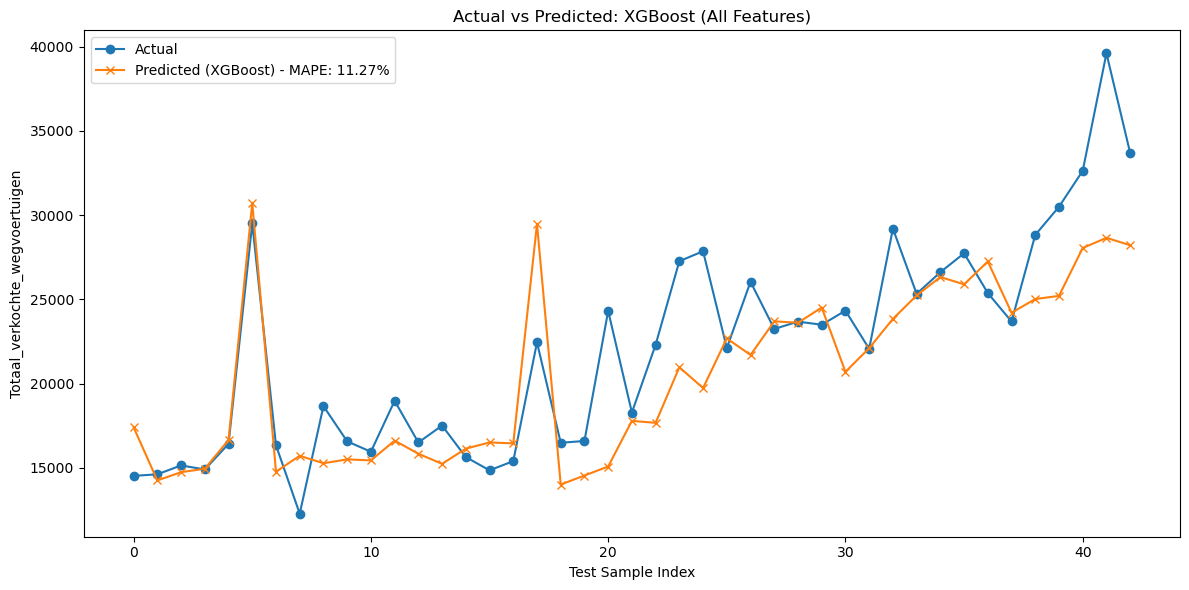

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import xgboost as xgb

def walk_forward_validation(df, features, target_col):
    """
    Perform walk-forward validation using XGBoost on the given dataframe.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, #200
    learning_rate=0.1,
    max_depth=3,#5
    random_state=42,
    eval_metric="rmse")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

# Evaluate updated configurations
results = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'Totaal_verkochte_wegvoertuigen')
    results.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)
import matplotlib.pyplot as plt

# Get predictions and actuals for the "All Features" set
mae, rmse, r2, mape = walk_forward_validation(df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen')
X = df_lagged[all_features].values
y = df_lagged['Totaal_verkochte_wegvoertuigen'].values
initial_train_size = int(len(df_lagged) * 0.8)
xgb_preds = []
xgb_actuals = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,
                             learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    xgb_preds.append(y_pred)
    xgb_actuals.append(y_test)

xgb_preds = np.array(xgb_preds)
xgb_actuals = np.array(xgb_actuals)
xgb_mape = np.mean(np.abs((xgb_actuals - xgb_preds) / xgb_actuals)) * 100

plt.figure(figsize=(12, 6))
plt.plot(xgb_actuals, label='Actual', marker='o')
plt.plot(xgb_preds, label=f'Predicted (XGBoost) - MAPE: {xgb_mape:.2f}%', marker='x')
plt.title('Actual vs Predicted: XGBoost (All Features)')
plt.xlabel('Test Sample Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()


#### Bayaans optimalisation

In [ ]:
%pip install bayesian-optimization

from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Simulated placeholder for df_lagged and all_features (not executable without real data)
# In a real environment, df_lagged and features must be provided

# Define the optimization function
def xgb_walk_forward_eval(learning_rate, max_depth, n_estimators):
    learning_rate = float(learning_rate)
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    X = df_lagged[all_features].values
    y = df_lagged['Totaal_verkochte_wegvoertuigen'].values
    initial_train_size = int(len(df_lagged) * 0.8)
    predictions = []
    actuals = []

    for i in range(initial_train_size, len(df_lagged)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]

        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators,
            random_state=42,
            eval_metric='rmse'
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return -mape  # Negative because BayesianOptimization maximizes

# Set the parameter bounds
param_bounds = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'n_estimators': (50, 300)
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_walk_forward_eval,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# Limited init_points and n_iter for demo purposes
optimizer.maximize(init_points=3, n_iter=5)

# Show best result
optimizer.max


Note: you may need to restart the kernel to use updated packages.
|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -12.89    | 0.1186    | 9.655     | 233.0     |
| 2         | -12.5     | 0.1836    | 4.092     | 89.0      |
| 3         | -13.62    | 0.02684   | 9.063     | 200.3     |
| 4         | -12.07    | 0.1726    | 5.325     | 88.74     |
| 5         | -12.84    | 0.1512    | 7.446     | 88.28     |
| 6         | -12.58    | 0.191     | 5.105     | 87.42     |
| 7         | -12.53    | 0.1386    | 5.977     | 89.85     |
| 8         | -12.0     | 0.2849    | 3.973     | 91.38     |


{'target': -11.999237674558632,
 'params': {'learning_rate': 0.284858712631848,
  'max_depth': 3.972596944691725,
  'n_estimators': 91.37690171421102}}

              Model          MAE         RMSE        R²   MAPE (%)
0        (Lag Only)  2803.870117  3589.379055  0.668574  12.665378
1    Keywords + Lag  2826.481934  3710.748442  0.645782  12.577656
2  Bijtelling + Lag  2760.362793  3563.105247  0.673408  12.473075
3  Confidence + Lag  2485.352051  3429.161559  0.697501  10.888869
4        Fuel + Lag  2850.468506  3925.974529  0.603500  12.360591
5      All Features  2539.339111  3581.372223  0.670051  10.727273


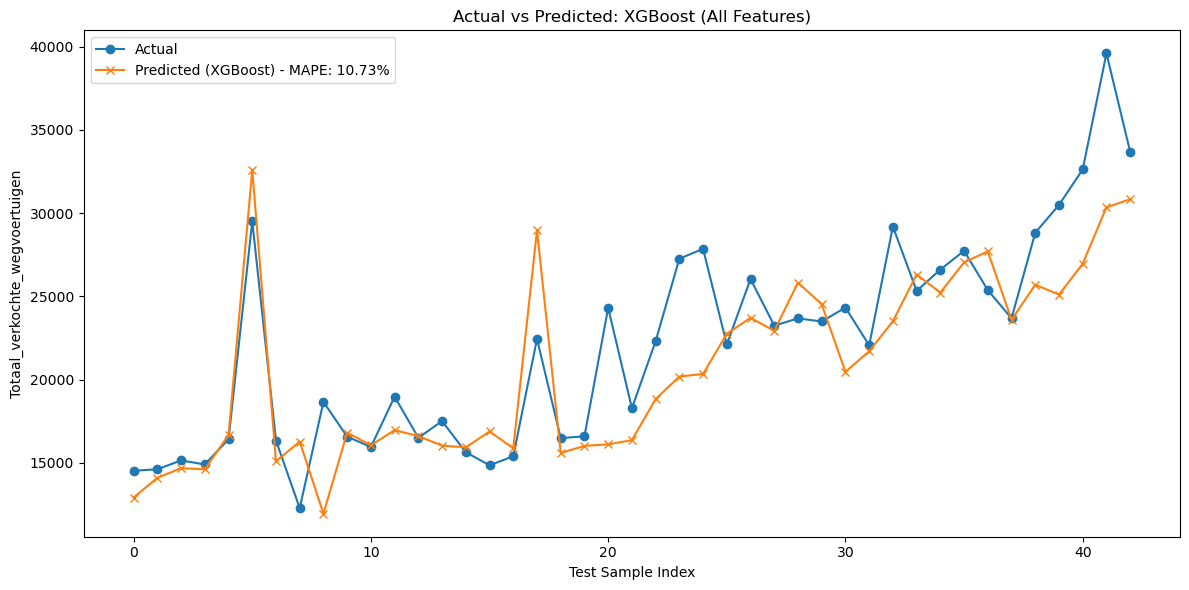

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def walk_forward_validation(df, features, target_col):
    """
    Perform walk-forward validation using XGBoost on the given dataframe.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=0.285,
            max_depth=4,
            n_estimators=91,
            random_state=42,
            eval_metric="mape"
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

# Evaluate updated configurations
results = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'Totaal_verkochte_wegvoertuigen')
    results.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)

import matplotlib.pyplot as plt

# Get predictions and actuals for the "All Features" set
X = df_lagged[all_features].values
y = df_lagged['Totaal_verkochte_wegvoertuigen'].values
initial_train_size = int(len(df_lagged) * 0.8)
xgb_preds = []
xgb_actuals = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.285,
        max_depth=4,
        n_estimators=91,
        random_state=42,
        eval_metric="mape"
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    xgb_preds.append(y_pred)
    xgb_actuals.append(y_test)

xgb_preds = np.array(xgb_preds)
xgb_actuals = np.array(xgb_actuals)
xgb_mape = np.mean(np.abs((xgb_actuals - xgb_preds) / xgb_actuals)) * 100

plt.figure(figsize=(12, 6))
plt.plot(xgb_actuals, label='Actual', marker='o')
plt.plot(xgb_preds, label=f'Predicted (XGBoost) - MAPE: {xgb_mape:.2f}%', marker='x')
plt.title('Actual vs Predicted: XGBoost (All Features)')
plt.xlabel('Test Sample Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()





MAPE Baseline (Lag Only): 13.61%
MAPE All Features: 12.45%


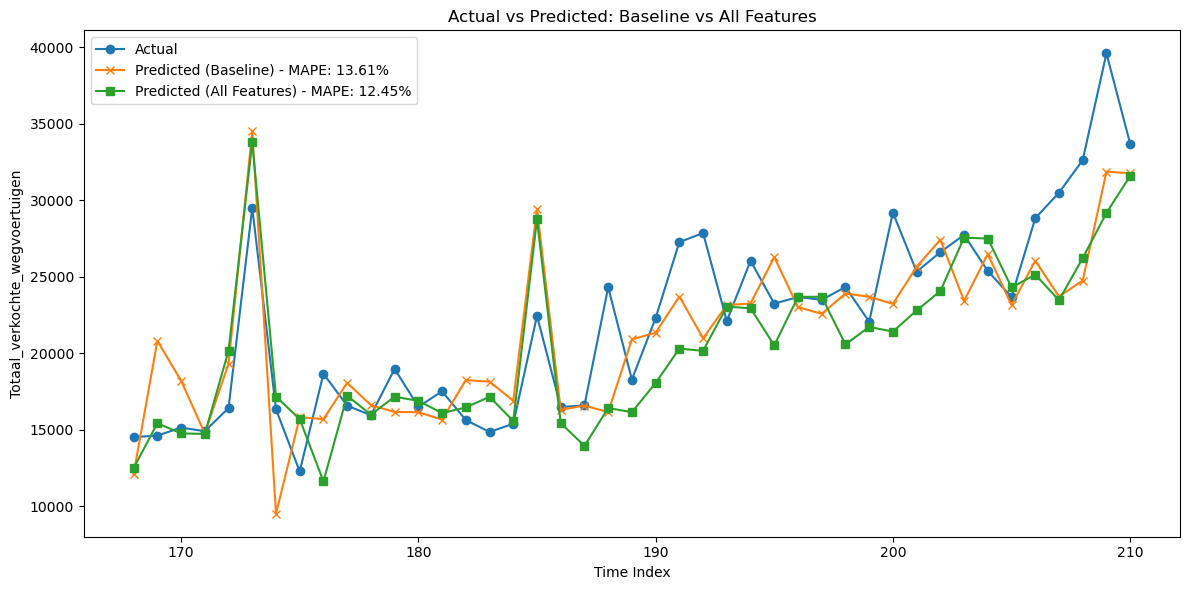

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Baseline (Lag Only) features
baseline_features = feature_sets[' (Lag Only)']

# Walk-forward predictions for baseline
X_baseline = df_lagged[baseline_features].values
y_baseline = df_lagged['Totaal_verkochte_wegvoertuigen'].values
baseline_preds = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X_baseline[:i], y_baseline[:i]
    X_test = X_baseline[i]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, eval_metric="rmse")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    baseline_preds.append(y_pred)

# 'All Features' gebruiken voor XGBoost walk-forward validatie
all_features = feature_sets['All Features']
X_all = df_lagged[all_features].values
y_all = df_lagged['Totaal_verkochte_wegvoertuigen'].values
all_preds = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X_all[:i], y_all[:i]
    X_test = X_all[i]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, eval_metric="rmse")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    all_preds.append(y_pred)

# Bereken MAPE voor beide modellen
mape_baseline = mean_absolute_percentage_error(y_baseline[initial_train_size:], baseline_preds) * 100
mape_all = mean_absolute_percentage_error(y_all[initial_train_size:], all_preds) * 100

print(f"MAPE Baseline (Lag Only): {mape_baseline:.2f}%")
print(f"MAPE All Features: {mape_all:.2f}%")

# Plot actual vs predicted for both models in one figure
plt.figure(figsize=(12, 6))
idx = range(initial_train_size, len(df_lagged))
plt.plot(idx, y_baseline[initial_train_size:], label='Actual', marker='o')
plt.plot(idx, baseline_preds, label=f'Predicted (Baseline) - MAPE: {mape_baseline:.2f}%', marker='x')
plt.plot(idx, all_preds, label=f'Predicted (All Features) - MAPE: {mape_all:.2f}%', marker='s')
plt.title('Actual vs Predicted: Baseline vs All Features')
plt.xlabel('Time Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()


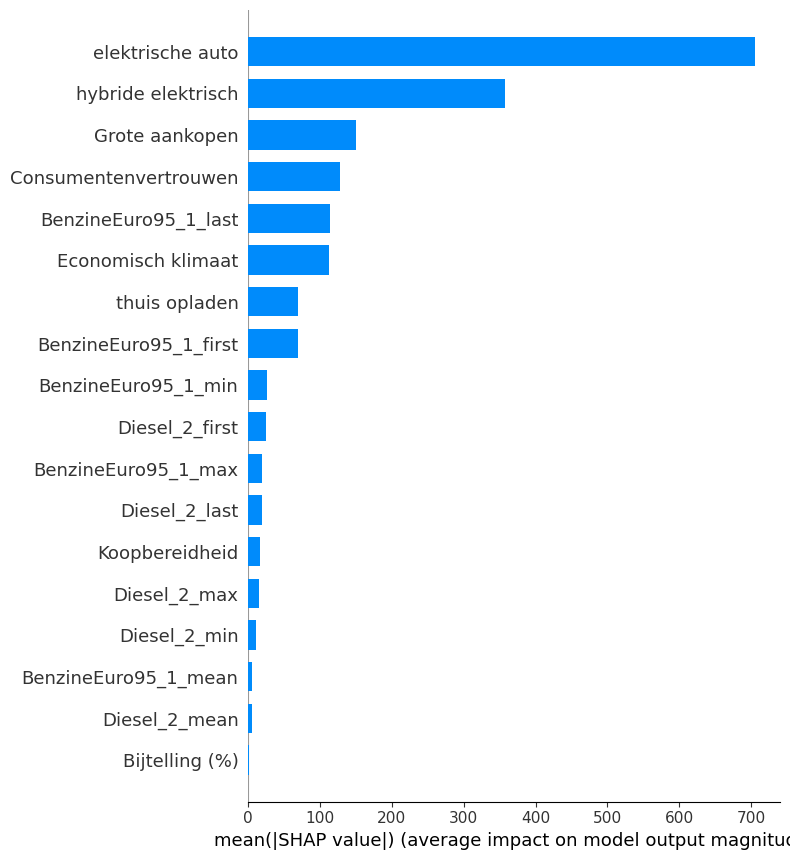

In [32]:
import shap

# Define lag + time features to exclude from SHAP display
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Prepare full feature matrix and target
X = df_lagged[feature_cols].values
y = df_lagged['Totaal_verkochte_wegvoertuigen'].values

# Train model on all features
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, eval_metric="rmse")
model.fit(X, y)

# Compute SHAP values on all features
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Select only the non-lag/time features for plotting
shap_features_display = [f for f in feature_cols if f not in lag_time_features]

# Use SHAP values only for selected features
shap.summary_plot(
    shap_values[:, [feature_cols.index(f) for f in shap_features_display]],
    df_lagged[shap_features_display],
    plot_type="bar"
)


### 6 maanden in te toekomst voorspellen

#### Linear regression

In [ ]:
def walk_forward_validation(df, features, target_col, forecast_horizon=10):
    """
    Perform walk-forward validation using Linear Regression to predict 'forecast_horizon' months ahead.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []

    # Make sure there's room for forecasting horizon
    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        X_train, y_train = X[:i], y[:i]
        X_test = X[i].reshape(1, -1)
        y_test = y[i + forecast_horizon - 1]  # 6-month ahead prediction

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]

        predictions.append(y_pred)
        actuals.append(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    return mae, rmse, r2, mape

mae, rmse, r2, mape = walk_forward_validation(df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen', forecast_horizon=6)

print(f"Linear Regression Walk-Forward (6-Month Forecast):")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")



Linear Regression Walk-Forward (6-Month Forecast):
MAPE: 16.64%
MAE: 4024.60
RMSE: 5516.96
R²: 0.1732


LR All features

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def walk_forward_validation(df, features, target_col, forecast_horizon=6):
    """
    Perform walk-forward validation using Linear Regression to predict 'forecast_horizon' steps ahead.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []

    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        X_train, y_train = X[:i], y[:i]
        X_test = X[i].reshape(1, -1)
        y_test = y[i + forecast_horizon - 1]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]

        predictions.append(y_pred)
        actuals.append(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Example usage:
mae, rmse, r2, mape = walk_forward_validation(df_lagged, feature_cols, 'Totaal_verkochte_wegvoertuigen', forecast_horizon=6)

print(f"Linear Regression Walk-Forward (6-Month Forecast):")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")



Linear Regression Walk-Forward (6-Month Forecast):
MAPE: 30.11%
MAE: 5789.91
RMSE: 7953.88
R²: -0.8096


#### LR with Elastic Net

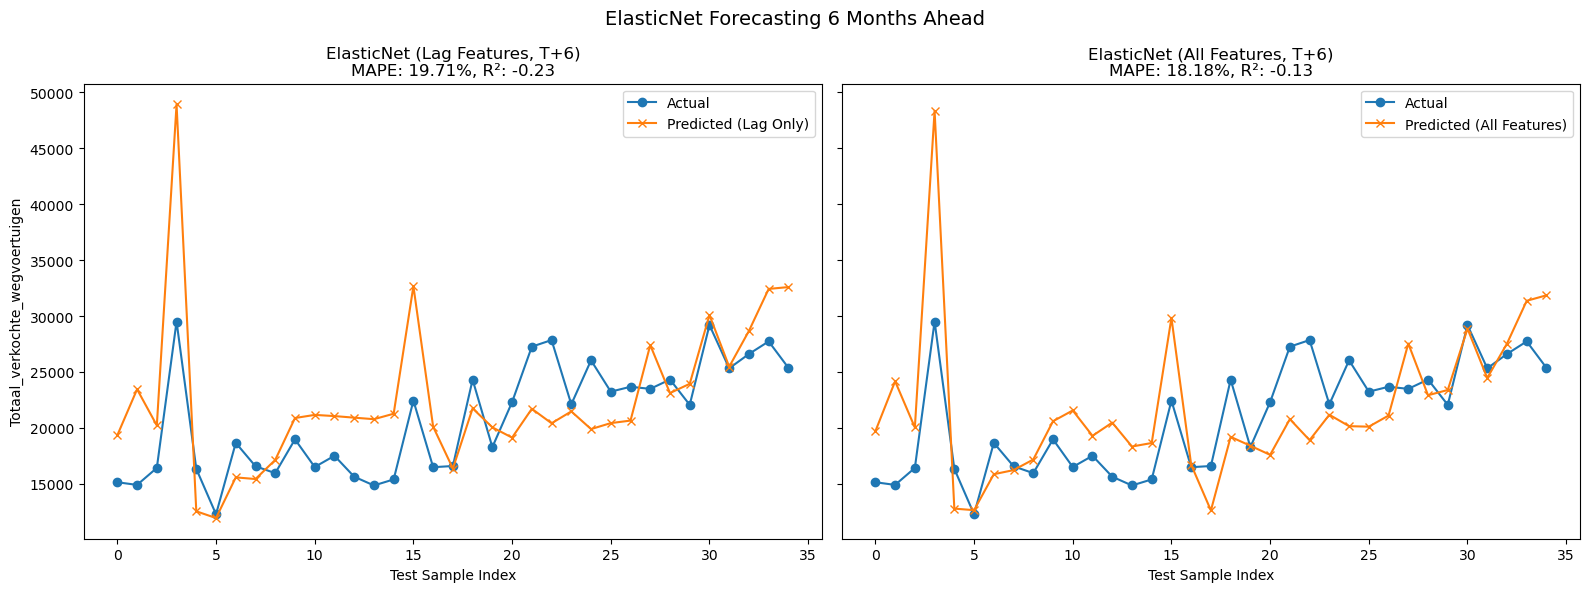

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def walk_forward_validation_elasticnet(df, features, target_col, alpha=1.0, l1_ratio=0.5, forecast_horizon=6):
    """
    Walk-forward validation using ElasticNet, predicting forecast_horizon months ahead.
    """
    X = df[features].values
    y = df[target_col].shift(-forecast_horizon).values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []

    for i in range(initial_train_size, len(df) - forecast_horizon):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]

        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]
        predictions.append(y_pred)
        actuals.append(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    return mae, rmse, r2, mape, predictions, actuals

# Set forecast horizon
forecast_horizon = 6

# --- Model 1: Lagged features only ---
mae1, rmse1, r2_1, mape1, preds1, actuals1 = walk_forward_validation_elasticnet(
    df_lagged, lagged_features, 'Totaal_verkochte_wegvoertuigen', forecast_horizon=forecast_horizon
)

# --- Model 2: All features ---
mae2, rmse2, r2_2, mape2, preds2, actuals2 = walk_forward_validation_elasticnet(
    df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', forecast_horizon=forecast_horizon
)

# --- Plotting side-by-side ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axs[0].plot(actuals1, label='Actual', marker='o')
axs[0].plot(preds1, label='Predicted (Lag Only)', marker='x')
axs[0].set_title(f'ElasticNet (Lag Features, T+{forecast_horizon})\nMAPE: {mape1:.2f}%, R²: {r2_1:.2f}')
axs[0].set_xlabel('Test Sample Index')
axs[0].set_ylabel('Totaal_verkochte_wegvoertuigen')
axs[0].legend()

axs[1].plot(actuals2, label='Actual', marker='o')
axs[1].plot(preds2, label='Predicted (All Features)', marker='x')
axs[1].set_title(f'ElasticNet (All Features, T+{forecast_horizon})\nMAPE: {mape2:.2f}%, R²: {r2_2:.2f}')
axs[1].set_xlabel('Test Sample Index')
axs[1].legend()

plt.suptitle(f'ElasticNet Forecasting {forecast_horizon} Months Ahead', fontsize=14)
plt.tight_layout()
plt.show()


#### Arima

In [ ]:
def walk_forward_arima(df, target_col, order=(1,1,1), forecast_horizon=9):
    """
    Walk-forward validation using ARIMA (univariate) to predict 'forecast_horizon' steps ahead.
    """
    y = df[target_col].values
    predictions = []
    actuals = []
    initial_train_size = int(len(df) * 0.8)

    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        train_y = y[:i]
        test_y = y[i + forecast_horizon - 1]  # 6 months ahead

        model = ARIMA(train_y, order=order)
        model_fit = model.fit()
        y_pred = model_fit.forecast(steps=forecast_horizon)[-1]

        predictions.append(y_pred)
        actuals.append(test_y)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape


# Evaluate ARIMA (univariate, only target column)
mae, rmse, r2, mape = walk_forward_arima(df_lagged, 'Totaal_verkochte_wegvoertuigen', order=(1,1,1))
print(f"ARIMA Walk-Forward:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.3f}\nMAPE: {mape:.2f}%")



ARIMA Walk-Forward:
MAE: 5078.35
RMSE: 6091.11
R²: -0.086
MAPE: 20.47%


Arimax

In [ ]:
def walk_forward_arimax(df, target_col, exog_cols, order=(1,1,1), forecast_horizon=6):
    """
    Walk-forward validation using ARIMAX (SARIMAX with exogenous variables) to predict 'forecast_horizon' steps ahead.
    """
    y = df[target_col].values
    X = df[exog_cols].values
    predictions = []
    actuals = []
    initial_train_size = int(len(df) * 0.8)

    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        train_y = y[:i]
        train_X = X[:i]
        test_X = X[i:i + forecast_horizon]  # Horizon-step exog features
        test_y = y[i + forecast_horizon - 1]  # true y value at that horizon

        model = SARIMAX(train_y, exog=train_X, order=order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)

        y_pred = model_fit.forecast(steps=forecast_horizon, exog=test_X)[-1]  # last step forecast

        predictions.append(y_pred)
        actuals.append(test_y)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape



# Use all_features as exogenous variables
mae, rmse, r2, mape = walk_forward_arimax(df_lagged, 'Totaal_verkochte_wegvoertuigen', all_features, order=(1,1,1))
print(f"ARIMAX Walk-Forward:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.3f}\nMAPE: {mape:.2f}%")

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

ARIMAX Walk-Forward:
MAE: 1983800085392.44
RMSE: 5223364177622.92
R²: -780405118719831296.000
MAPE: 11067716046.61%


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Xgboost

In [ ]:
def walk_forward_validation(df, features, target_col, forecast_horizon=6):
    """
    Perform walk-forward validation using XGBoost to predict 'forecast_horizon' steps ahead.
    Returns MAE, RMSE, R2, and MAPE.
    """
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        X_train, y_train = X[:i], y[:i]
        X_test = X[i].reshape(1, -1)
        y_test = y[i + forecast_horizon - 1]  # 6-step ahead target
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=0.285,
            max_depth=4,
            n_estimators=91,
            random_state=42,
            eval_metric="mape"
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mae, rmse, r2, mape

# Evaluate updated configurations for forecast horizon = 6
results_lead6 = []
for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'Totaal_verkochte_wegvoertuigen', forecast_horizon=6)
    results_lead6.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

results_df_lead6 = pd.DataFrame(results_lead6)
print(results_df_lead6)


              Model          MAE         RMSE        R²   MAPE (%)
0        (Lag Only)  4650.514160  6638.970101 -0.197238  20.026183
1    Keywords + Lag  4966.945312  6759.534599 -0.241117  21.444671
2  Bijtelling + Lag  4696.105957  6657.866325 -0.204063  20.185487
3  Confidence + Lag  4842.477051  6452.680683 -0.130992  20.687187
4        Fuel + Lag  4818.948242  6457.724367 -0.132761  20.728734
5      All Features  4943.124023  6573.135629 -0.173611  20.742417


In [ ]:
from bayes_opt import BayesianOptimization
import xgboost as xgb

def xgb_walk_forward_eval(learning_rate, max_depth, n_estimators):
    learning_rate = float(learning_rate)
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    X = df_lagged[all_features].values
    y = df_lagged['Totaal_verkochte_wegvoertuigen'].values
    initial_train_size = int(len(df_lagged) * 0.8)
    predictions = []
    actuals = []
    for i in range(initial_train_size, len(df_lagged) - 6 + 1):
        X_train, y_train = X[:i], y[:i]
        X_test = X[i].reshape(1, -1)
        y_test = y[i + 6 - 1]  # 6-step ahead
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators,
            random_state=42,
            eval_metric='mape'
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return -mape  # Negative for maximization

param_bounds = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'n_estimators': (50, 300)
}

optimizer = BayesianOptimization(
    f=xgb_walk_forward_eval,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=3, n_iter=5)

print("Best parameters and (negative) MAPE found:")
print(optimizer.max)


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -22.77    | 0.1186    | 9.655     | 233.0     |
| 2         | -23.26    | 0.1836    | 4.092     | 89.0      |
| 3         | -23.19    | 0.02684   | 9.063     | 200.3     |
| 4         | -23.45    | 0.1681    | 9.653     | 231.9     |
| 5         | -23.42    | 0.2597    | 9.674     | 232.8     |
| 6         | -22.74    | 0.1043    | 6.354     | 85.7      |
| 7         | -22.9     | 0.2835    | 5.575     | 105.3     |
| 8         | -23.67    | 0.2693    | 9.031     | 153.3     |
Best parameters and (negative) MAPE found:
{'target': -22.737985805909442, 'params': {'learning_rate': 0.10431738009451684, 'max_depth': 6.35375359814579, 'n_estimators': 85.69663475544462}}


XGBoost Walk-Forward (6-month lead, optimized params):
MAPE: 12.46%
MAE: 2993.68
RMSE: 4041.59
R²: 0.5692


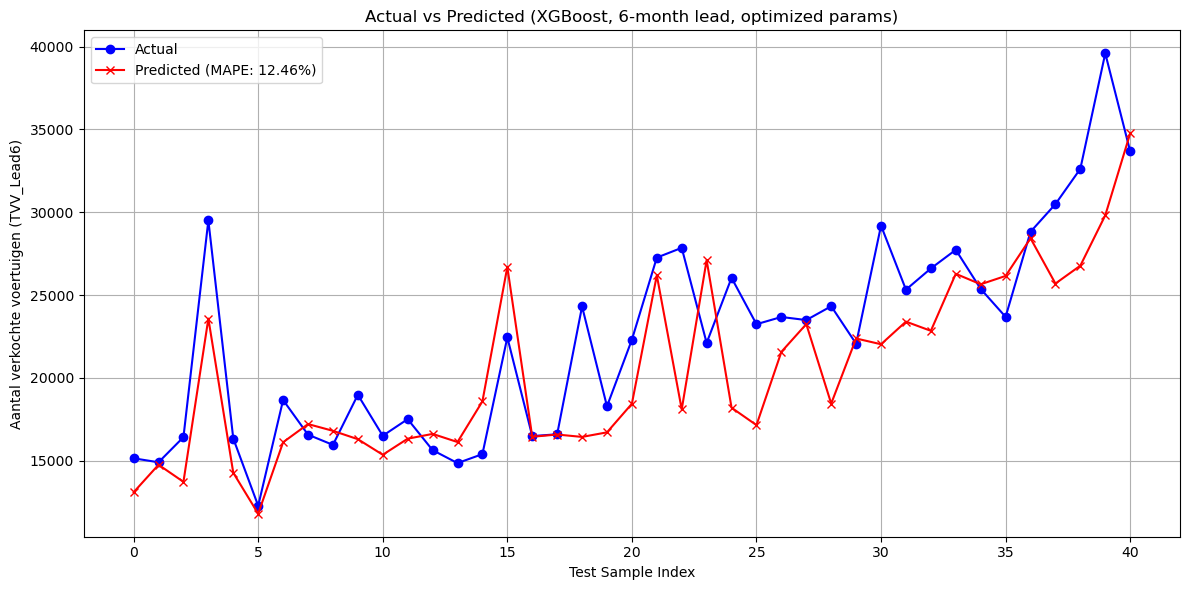

In [ ]:
# Use the best parameters from Bayesian Optimization for XGBoost walk-forward validation (6-month lead)
best_params = {
    'learning_rate': 0.10534330360014878,
    'max_depth': int(round(6.2158736923029)),
    'n_estimators': int(round(200.64814942309243)),
    'objective': 'reg:squarederror',
    'random_state': 42,
    'eval_metric': 'mape'
}

# Use 'All Features' and 6-month lead target
X = df_lagged[feature_sets['All Features']].values
y = df_lagged['TVV_Lead6'].values
initial_train_size = int(len(df_lagged) * 0.8)
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    predictions.append(y_pred)
    actuals.append(y_test)

predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print("XGBoost Walk-Forward (6-month lead, optimized params):")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual", marker='o', color='blue')
plt.plot(predictions, label=f"Predicted (MAPE: {mape:.2f}%)", marker='x', color='red')
plt.title("Actual vs Predicted (XGBoost, 6-month lead, optimized params)")
plt.xlabel("Test Sample Index")
plt.ylabel("Aantal verkochte voertuigen (TVV_Lead6)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

def walk_forward_validation(df, features, target_col, forecast_horizon=3):
    """
    Perform walk-forward validation to forecast 'forecast_horizon' months ahead.
    """
    X = df[features].values
    y = df[target_col].shift(-forecast_horizon).values
    initial_train_size = int(len(df) * 0.8)

    predictions = []
    actuals = []

    for i in range(initial_train_size, len(df) - forecast_horizon):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]

        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=0.285,
            max_depth=4,
            n_estimators=91,
            random_state=42,
            eval_metric="mape"
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test.reshape(1, -1))[0]

        predictions.append(y_pred)
        actuals.append(y_test)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    return mae, rmse, r2, mape, predictions, actuals





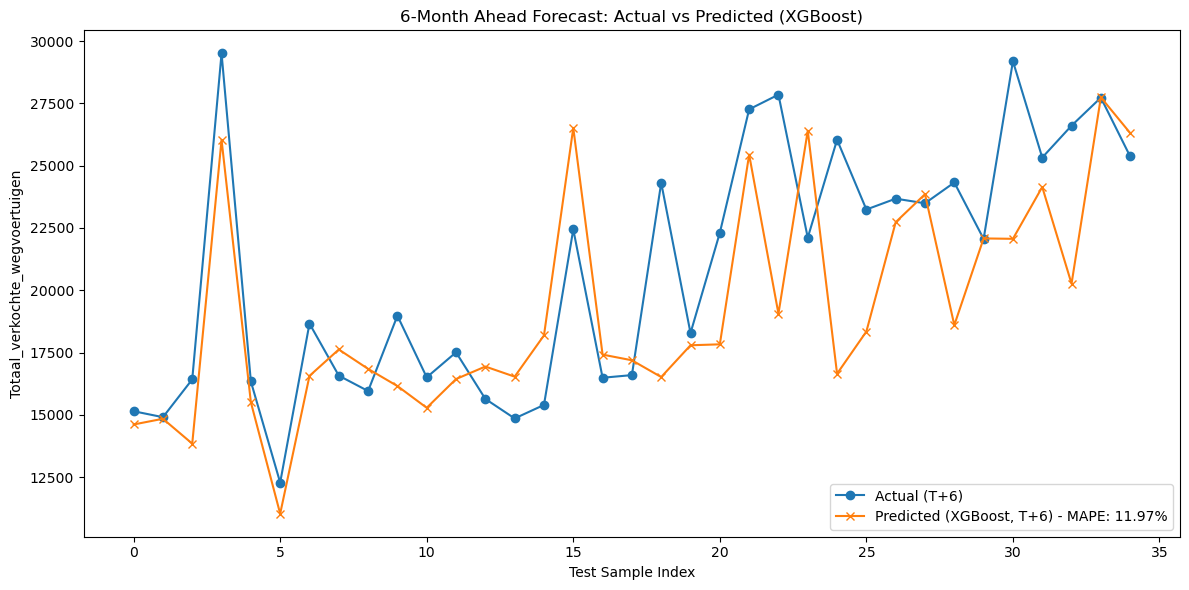

In [ ]:
forecast_horizon = 6  # just change to 3, 6, or 9

# Evaluate and collect predictions for 'All Features'
mae, rmse, r2, mape, preds, actuals = walk_forward_validation(
    df_lagged, all_features, 'Totaal_verkochte_wegvoertuigen', forecast_horizon=forecast_horizon
)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(actuals, label=f'Actual (T+{forecast_horizon})', marker='o')
plt.plot(preds, label=f'Predicted (XGBoost, T+{forecast_horizon}) - MAPE: {mape:.2f}%', marker='x')
plt.title(f'{forecast_horizon}-Month Ahead Forecast: Actual vs Predicted (XGBoost)')
plt.xlabel('Test Sample Index')
plt.ylabel('Totaal_verkochte_wegvoertuigen')
plt.legend()
plt.tight_layout()
plt.show()


### 6 maanden lead target value toegevoegd 

In [ ]:
# Step 1: Add 6-month lead target column
df_lagged['TVV_Lead6'] = df_lagged['Totaal_verkochte_wegvoertuigen'].shift(-6)

# Step 2: Drop last 6 rows (which now have NaN targets)
df_lagged = df_lagged.dropna(subset=['TVV_Lead6'])

# Step 3: Re-run the same model evaluations but targeting 6-months ahead
results_lead6 = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'TVV_Lead6')
    results_lead6.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

results_df_lead6 = pd.DataFrame(results_lead6)

print(results_df_lead6)



              Model          MAE         RMSE        R²   MAPE (%)
0        (Lag Only)  4573.154215  5561.979168  0.151299  18.756764
1    Keywords + Lag  4628.211100  5704.446645  0.107264  18.735923
2  Bijtelling + Lag  4577.087619  5569.213845  0.149089  18.774162
3  Confidence + Lag  4611.176215  5746.582814  0.094026  18.642441
4        Fuel + Lag  4722.643934  5714.741774  0.104038  19.329892
5      All Features  4928.194499  6047.417184 -0.003312  20.489102


In [ ]:
# Step 1: Add 6-month lead target column
df_lagged['TVV_Lead6'] = df_lagged['Totaal_verkochte_wegvoertuigen'].shift(-6)

# Step 2: Drop last 6 rows (which now have NaN targets)
df_lagged = df_lagged.dropna(subset=['TVV_Lead6'])

# Step 3: Re-run the same model evaluations but targeting 6-months ahead
results_lead6 = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'TVV_Lead6')
    results_lead6.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

results_df_lead6 = pd.DataFrame(results_lead6)

print(results_df_lead6)




              Model          MAE         RMSE        R²   MAPE (%)
0        (Lag Only)  2760.612744  4014.035000  0.413491  12.603942
1    Keywords + Lag  2823.967187  4002.252076  0.416929  13.043977
2  Bijtelling + Lag  2751.146289  4011.748778  0.414159  12.561429
3  Confidence + Lag  2917.921069  4189.068124  0.361226  13.097761
4        Fuel + Lag  2777.274976  3959.107373  0.429433  12.758531
5      All Features  2553.773901  3584.297842  0.532351  12.029105


Alle variablen 

In [ ]:
# Use all features (feature_cols) for model training and walk-forward validation (no early stopping)

X_all = df_lagged[feature_cols].values
y_all = df_lagged[target_col].values

initial_train_size_all = int(len(df_lagged) * 0.8)
predictions_all = []
actuals_all = []

for i in range(initial_train_size_all, len(df_lagged)):
    X_train_all, y_train_all = X_all[:i], y_all[:i]
    X_test_all, y_test_all = X_all[i], y_all[i]

    model_all = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric="rmse"
    )

    model_all.fit(X_train_all, y_train_all)

    y_pred_all = model_all.predict(X_test_all.reshape(1, -1))[0]
    predictions_all.append(y_pred_all)
    actuals_all.append(y_test_all)

# Evaluation
mae_all = mean_absolute_error(actuals_all, predictions_all)
rmse_all = np.sqrt(mean_squared_error(actuals_all, predictions_all))
r2_all = r2_score(actuals_all, predictions_all)
mape_all = np.mean(np.abs((np.array(actuals_all) - np.array(predictions_all)) / np.array(actuals_all))) * 100

print("📈 Walk-Forward Validation Results (All Features, No Early Stopping)")
print(f"MAE:  {mae_all:.2f}")
print(f"RMSE: {rmse_all:.2f}")
print(f"R²:   {r2_all:.4f}")
print(f"MAPE: {mape_all:.2f}%")


plt.figure(figsize=(12, 6))
plt.plot(actuals_all, label="Actual", marker='o', color='blue')
plt.plot(predictions_all, label="Predicted", marker='x', color='red')
plt.title("Actual vs Predicted (Walk-Forward Validation, All Features)")
plt.xlabel("Test Sample Index")
plt.ylabel("Aantal verkochte voertuigen")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

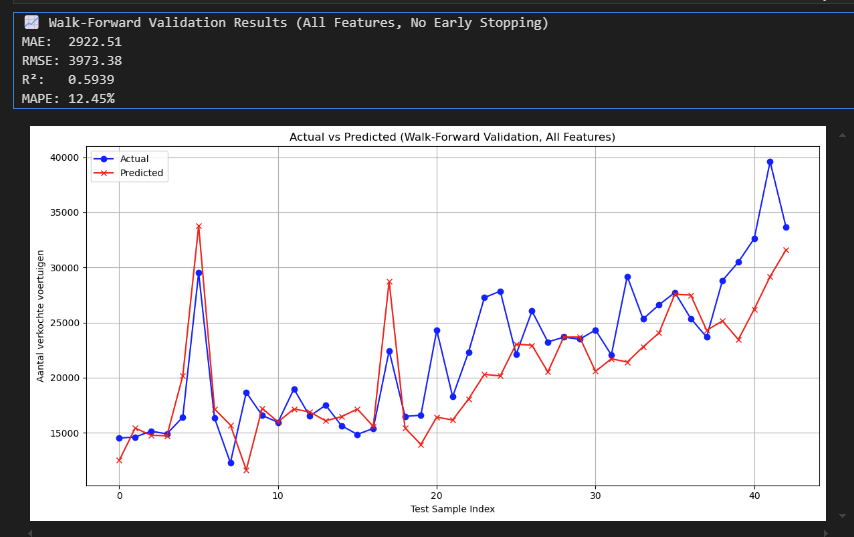